## **实验 1.2 Robust PCA for moving object detection**

### **Robust PCA 模型**

$$
\min_{L,S} \|L\|_* + \lambda \|S\|_1, \quad \text{s.t. } Y = L + S
$$

其中：
- $\|L\|_*$ 是矩阵 L 的核范数（所有奇异值之和），鼓励 L 低秩
- $\|S\|_1$ 是矩阵 S 的元素绝对值之和，鼓励 S 稀疏
- $\lambda > 0$ 是权衡两项的参数

### **ADMM 算法**

定义增广拉格朗日函数：
$$
\mathcal{L}(L,S,Z) = \|L\|_* + \lambda \|S\|_1 + \langle Z, Y - L - S \rangle + \frac{\mu}{2} \|Y - L - S\|_F^2
$$
交替更新 L, S, Z：
1. 更新$L$(奇异值阈值化)：
   $$L^{k+1} = \arg\min_L \mathcal{L}(L, S^k, Z^k)$$
   通过对矩阵 $Y - S^k + \frac{1}{\mu} Z^k$ 进行奇异值分解 (SVD)，然后对奇异值进行阈值化求解
2. 更新$S$（元素阈值化）：
   $$S^{k+1} = \arg\min_S \mathcal{L}(L^{k+1}, S, Z^k)$$
   通过对矩阵 $Y - L^{k+1} + \frac{1}{\mu} Z^k$ 进行元素阈值化求解
3. 更新$Z$：
   $$Z^{k+1} = Z^k + \mu (Y - L^{k+1} - S^{k+1})$$

### **实验步骤**
1. 下载并加载 Wallflower MovedObject 数据集
2. 预处理图像（灰度化、裁剪、归一化）
3. 构建 observation matrix Y (19200 x 20)，运行 Robust PCA via ADMM 分解 Y = L + S
4. 保存每帧的原图 / 低秩背景 L / 稀疏前景 S 到 output 文件夹，并保存 numpy 文件


未开启自动下载，使用本地数据目录： ./MovedObject
找到 1746 张图片，示例：['./MovedObject/b00000.bmp', './MovedObject/b00001.bmp', './MovedObject/b00002.bmp', './MovedObject/b00003.bmp', './MovedObject/b00004.bmp']
选中的帧索引与路径：
1744 ./MovedObject/b01744.bmp
1745 ./MovedObject/hand_segmented_00985.BMP
1499 ./MovedObject/b01499.bmp
1500 ./MovedObject/b01500.bmp
1498 ./MovedObject/b01498.bmp
1496 ./MovedObject/b01496.bmp
1497 ./MovedObject/b01497.bmp
1394 ./MovedObject/b01394.bmp
1495 ./MovedObject/b01495.bmp
1393 ./MovedObject/b01393.bmp
1392 ./MovedObject/b01392.bmp
1395 ./MovedObject/b01395.bmp
887 ./MovedObject/b00887.bmp
643 ./MovedObject/b00643.bmp
642 ./MovedObject/b00642.bmp
1494 ./MovedObject/b01494.bmp
641 ./MovedObject/b00641.bmp
884 ./MovedObject/b00884.bmp
886 ./MovedObject/b00886.bmp
649 ./MovedObject/b00649.bmp
构建 observation matrix Y, shape= (19200, 20)
Running Robust PCA with lambda=7.2169e-03, mu=0.001, max_iter=500, num_frames=20
iter    0, rel_err=3.229e-02
iter   50, rel_err=4.125e-04
iter  100, 

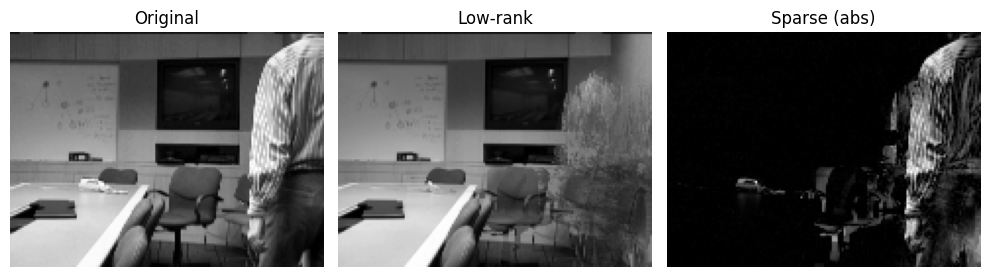

In [ ]:
"""

功能：
1) 尝试从微软下载 Wallflower MovedObject 数据集（若不可达，请手动下载并放到 local_data_dir）
2) 从数据集中读取所有图像，按帧间运动能量自动挑选 20 帧（可修改为手动选择）
3) 构建 observation matrix Y (19200 x 20)，运行 Robust PCA via ADMM 分解 Y = L + S
4) 保存每帧的原图 / 低秩背景 L / 稀疏前景 S 到 output 文件夹，并保存 numpy 文件

"""

import os
import sys
import numpy as np
import cv2
import zipfile
import requests
from io import BytesIO
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------ 用户可修改参数 ------------------
DOWNLOAD = False
DOWNLOAD_URL = "https://download.microsoft.com/download/MovedObject.zip" 
local_data_dir = "./MovedObject"   # 若下载失败，请把数据手动放这里（或改为你本地路径）
work_dir = "./rpca_output"
IMG_SIZE = (120, 160)  # height, width
START_FRAME = 638  # 从数据集中第几帧开始取
NUM_FRAMES = 20
LAMBDA = None  # 若 None 则自动设置为 1/sqrt(max(m,n))
MU = 1e-3
MAX_ITER = 500
TOL = 1e-7
VERBOSE = True
# ---------------------------------------------------

os.makedirs(local_data_dir, exist_ok=True)
os.makedirs(work_dir, exist_ok=True)

def try_download_and_extract(url, dest_folder):
    """
    尝试下载 zip 并解压到 dest_folder。
    如果下载失败或 URL 不可达，将返回 False。
    """
    try:
        print("尝试下载数据集...")
        # 逐块下载以显示进度
        resp = requests.get(url, stream=True, timeout=30)
        if resp.status_code != 200:
            print(f"下载失败: HTTP {resp.status_code}")
            return False
        total = int(resp.headers.get('content-length', 0))
        chunk_size = 1024*64
        bio = BytesIO()
        with tqdm(total=total, unit='B', unit_scale=True, desc='Downloading') as pbar:
            for chunk in resp.iter_content(chunk_size=chunk_size):
                if chunk:
                    bio.write(chunk)
                    pbar.update(len(chunk))
        bio.seek(0)
        print("解压缩...")
        with zipfile.ZipFile(bio) as z:
            z.extractall(dest_folder)
        print("下载并解压完成，文件位于：", dest_folder)
        return True
    except Exception as e:
        print("自动下载/解压失败：", e)
        return False

def gather_image_paths(root_dir):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    paths = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(exts):
                paths.append(os.path.join(root, f))
    paths = sorted(paths)
    return paths

def read_and_preprocess(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise RuntimeError(f"Failed to read image {path}")
    img = cv2.resize(img, (size[1], size[0]))  # cv2 resize uses (w,h)
    return img

def select_frames_by_motion(img_paths, size, num_select):
    """
    自动选择具有较多运动的帧：
    - 先读取并缩放所有帧为 size
    - 计算相邻帧 abs diff 的 sum（motion energy）
    - 选取得分最高的 num_select 帧
    """
    imgs = []
    for p in img_paths:
        try:
            imgs.append(read_and_preprocess(p, size))
        except:
            imgs.append(None)
    # 计算帧间差（对缺失的跳过）
    energies = []
    for i in range(len(imgs)):
        if imgs[i] is None:
            energies.append(0)
            continue
        # use diff to median of neighbors (previous and next if exist)
        neighbors = []
        if i-1 >= 0 and imgs[i-1] is not None:
            neighbors.append(imgs[i-1])
        if i+1 < len(imgs) and imgs[i+1] is not None:
            neighbors.append(imgs[i+1])
        if len(neighbors) == 0:
            energies.append(0)
            continue
        # compute average absolute difference to neighbors
        diffs = [np.abs(imgs[i].astype(np.float32) - n.astype(np.float32)) for n in neighbors]
        energy = np.sum(np.stack(diffs), axis=(1,2)).sum() if len(diffs)>1 else diffs[0].sum()
        energies.append(energy)
    indices = np.argsort(energies)[::-1]  # desc
    selected = []
    for idx in indices:
        if imgs[idx] is not None:
            selected.append((idx, img_paths[idx]))
        if len(selected) >= num_select:
            break
    return selected

# ------------------ Robust PCA (ADMM) 工具 ------------------
def svt(X, tau):
    # X: (m, n)
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    s_thresh = np.maximum(s - tau, 0)
    return (U * s_thresh) @ Vt  # broadcasting U * s -> U @ diag(s)

def shrink(X, tau):
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0.0)

def robust_pca_admm(Y, lam=None, mu=1e-3, max_iter=500, tol=1e-7, verbose=True):
    m, n = Y.shape
    if lam is None:
        lam = 1.0 / np.sqrt(max(m, n))
    L = np.zeros_like(Y)
    S = np.zeros_like(Y)
    Z = np.zeros_like(Y)
    normY = np.linalg.norm(Y, 'fro')
    for k in range(max_iter):
        # update L via SVT
        L = svt(Y - S + Z/mu, 1.0/mu)
        # update S via shrinkage
        S = shrink(Y - L + Z/mu, lam/mu)
        # dual update
        residual = Y - L - S
        Z = Z + mu * residual
        err = np.linalg.norm(residual, 'fro') / (normY + 1e-12)
        if verbose and (k % 50 == 0 or err < tol):
            print(f"iter {k:4d}, rel_err={err:.3e}")
        if err < tol:
            break
    return L, S

# ------------------ 主流程 ------------------
def main():
    # 1) 尝试自动下载 (如果 DOWNLOAD==True)
    if DOWNLOAD:
        ok = try_download_and_extract(DOWNLOAD_URL, local_data_dir)
        if not ok:
            print("自动下载未成功，请将数据集手动放到", local_data_dir)
    else:
        print("未开启自动下载，使用本地数据目录：", local_data_dir)

    # 2) 收集图片列表
    img_paths = gather_image_paths(local_data_dir)
    if len(img_paths) == 0:
        print("未在数据目录找到图片。请确认数据已解压或将图片放到：", local_data_dir)
        sys.exit(1)
    print(f"找到 {len(img_paths)} 张图片，示例：{img_paths[:5]}")

    # 3) 自动选帧或截取前 N 帧
    selected = select_frames_by_motion(img_paths, IMG_SIZE, NUM_FRAMES)
    if len(selected) < NUM_FRAMES:
        print("自动选帧不足，改为直接取前 N 张")
        selected = [(i, p) for i, p in enumerate(img_paths[START_FRAME:START_FRAME+NUM_FRAMES])]
    print("选中的帧索引与路径：")
    for idx, p in selected:
        print(idx, p)

    # 4) 构建 Y 矩阵
    images_vecs = []
    chosen_paths = []
    for idx, p in selected:
        img = read_and_preprocess(p, IMG_SIZE)
        images_vecs.append(img.flatten().astype(np.float32))
        chosen_paths.append(p)
    Y = np.column_stack(images_vecs)  # shape (m, n)
    m, n = Y.shape
    print("构建 observation matrix Y, shape=", Y.shape)

    # 5) 运行 Robust PCA (ADMM)
    lam = LAMBDA if LAMBDA is not None else 1.0 / np.sqrt(max(m, n))
    print(f"Running Robust PCA with lambda={lam:.4e}, mu={MU}, max_iter={MAX_ITER}, num_frames={NUM_FRAMES}")
    L, S = robust_pca_admm(Y, lam=lam, mu=MU, max_iter=MAX_ITER, tol=TOL, verbose=VERBOSE)

    # 6) 保存结果：每帧的原图 / L / S，和 .npy 文件
    np.save(os.path.join(work_dir, "Y.npy"), Y)
    np.save(os.path.join(work_dir, "L.npy"), L)
    np.save(os.path.join(work_dir, "S.npy"), S)
    print("保存矩阵 Y, L, S 到", work_dir)

    # 保存每帧图片
    for i in range(n):
        orig = Y[:, i].reshape(IMG_SIZE)
        low = L[:, i].reshape(IMG_SIZE)
        sprs = S[:, i].reshape(IMG_SIZE)
        # 为了可视化，将 low 和 sparse 做归一化显示
        low_disp = np.clip(low, 0, 255)
        # sparse 可能有正负，用绝对值并适当放大以便查看
        sprs_disp = np.clip(np.abs(sprs), 0, np.percentile(np.abs(sprs), 99))
        # normalize to 0-255
        low_disp = ((low_disp - low_disp.min()) / (np.ptp(low_disp) + 1e-12) * 255).astype(np.uint8)
        sprs_disp = ((sprs_disp - sprs_disp.min()) / (np.ptp(sprs_disp) + 1e-12) * 255).astype(np.uint8)
        orig_u = np.clip(orig, 0, 255).astype(np.uint8)

        out_orig = os.path.join(work_dir, f"frame_{i:03d}_orig.png")
        out_low  = os.path.join(work_dir, f"frame_{i:03d}_low.png")
        out_sprs = os.path.join(work_dir, f"frame_{i:03d}_sparse.png")
        cv2.imwrite(out_orig, orig_u)
        cv2.imwrite(out_low, low_disp)
        cv2.imwrite(out_sprs, sprs_disp)

        # 组合图
        combo = np.hstack([orig_u, low_disp, sprs_disp])
        cv2.imwrite(os.path.join(work_dir, f"frame_{i:03d}_combo.png"), combo)

    print("已保存每帧的结果图：", work_dir)

    # 7) 显示一个示例：第 n//2 帧
    idx_show = n // 2
    orig = Y[:, idx_show].reshape(IMG_SIZE)
    low = L[:, idx_show].reshape(IMG_SIZE)
    sprs = S[:, idx_show].reshape(IMG_SIZE)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.title("Original"); plt.imshow(orig, cmap='gray'); plt.axis('off')
    plt.subplot(1,3,2); plt.title("Low-rank"); plt.imshow(low, cmap='gray'); plt.axis('off')
    plt.subplot(1,3,3); plt.title("Sparse (abs)"); plt.imshow(np.abs(sprs), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

未开启自动下载，使用本地数据目录： ./MovedObject
找到 1746 张图片，示例：['./MovedObject/b00000.bmp', './MovedObject/b00001.bmp', './MovedObject/b00002.bmp', './MovedObject/b00003.bmp', './MovedObject/b00004.bmp']
选中的帧索引与路径：
1744 ./MovedObject/b01744.bmp
1745 ./MovedObject/hand_segmented_00985.BMP
1499 ./MovedObject/b01499.bmp
1500 ./MovedObject/b01500.bmp
1498 ./MovedObject/b01498.bmp
1496 ./MovedObject/b01496.bmp
1497 ./MovedObject/b01497.bmp
1394 ./MovedObject/b01394.bmp
1495 ./MovedObject/b01495.bmp
1393 ./MovedObject/b01393.bmp
1392 ./MovedObject/b01392.bmp
1395 ./MovedObject/b01395.bmp
887 ./MovedObject/b00887.bmp
643 ./MovedObject/b00643.bmp
642 ./MovedObject/b00642.bmp
1494 ./MovedObject/b01494.bmp
641 ./MovedObject/b00641.bmp
884 ./MovedObject/b00884.bmp
886 ./MovedObject/b00886.bmp
649 ./MovedObject/b00649.bmp
888 ./MovedObject/b00888.bmp
640 ./MovedObject/b00640.bmp
1391 ./MovedObject/b01391.bmp
883 ./MovedObject/b00883.bmp
885 ./MovedObject/b00885.bmp
1493 ./MovedObject/b01493.bmp
650 ./MovedObject/

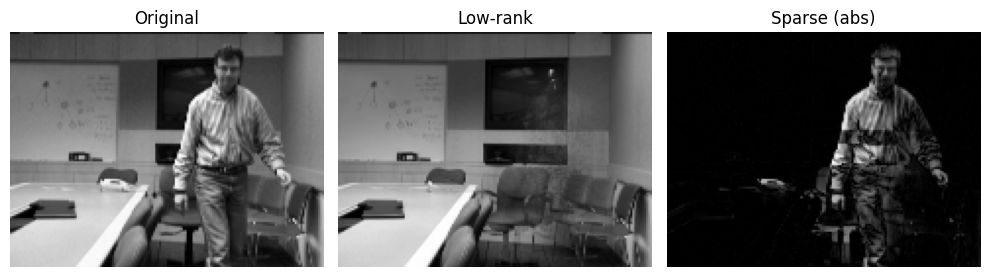

In [ ]:
# 尝试不同参数组合 （采用更多的图像（50））
START_FRAME = 638  # 从数据集中第几帧开始取
NUM_FRAMES = 50
LAMBDA = None  # 若 None 则自动设置为 1/sqrt(max(m,n))
MU = 1e-3
MAX_ITER = 500
TOL = 1e-7
VERBOSE = True

main()

未开启自动下载，使用本地数据目录： ./MovedObject
找到 1746 张图片，示例：['./MovedObject/b00000.bmp', './MovedObject/b00001.bmp', './MovedObject/b00002.bmp', './MovedObject/b00003.bmp', './MovedObject/b00004.bmp']
选中的帧索引与路径：
1744 ./MovedObject/b01744.bmp
1745 ./MovedObject/hand_segmented_00985.BMP
1499 ./MovedObject/b01499.bmp
1500 ./MovedObject/b01500.bmp
1498 ./MovedObject/b01498.bmp
1496 ./MovedObject/b01496.bmp
1497 ./MovedObject/b01497.bmp
1394 ./MovedObject/b01394.bmp
1495 ./MovedObject/b01495.bmp
1393 ./MovedObject/b01393.bmp
1392 ./MovedObject/b01392.bmp
1395 ./MovedObject/b01395.bmp
887 ./MovedObject/b00887.bmp
643 ./MovedObject/b00643.bmp
642 ./MovedObject/b00642.bmp
1494 ./MovedObject/b01494.bmp
641 ./MovedObject/b00641.bmp
884 ./MovedObject/b00884.bmp
886 ./MovedObject/b00886.bmp
649 ./MovedObject/b00649.bmp
888 ./MovedObject/b00888.bmp
640 ./MovedObject/b00640.bmp
1391 ./MovedObject/b01391.bmp
883 ./MovedObject/b00883.bmp
885 ./MovedObject/b00885.bmp
1493 ./MovedObject/b01493.bmp
650 ./MovedObject/

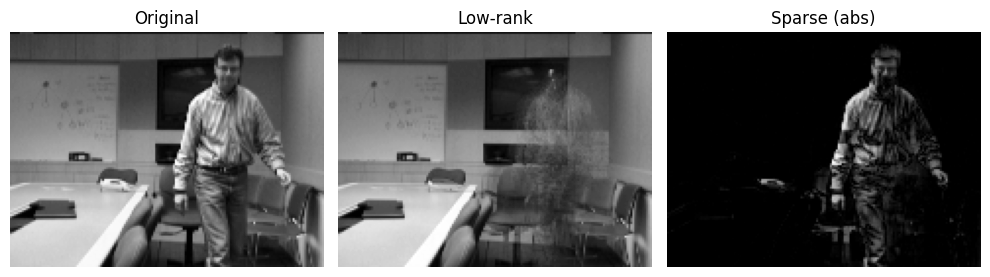

未开启自动下载，使用本地数据目录： ./MovedObject
找到 1746 张图片，示例：['./MovedObject/b00000.bmp', './MovedObject/b00001.bmp', './MovedObject/b00002.bmp', './MovedObject/b00003.bmp', './MovedObject/b00004.bmp']
选中的帧索引与路径：
1744 ./MovedObject/b01744.bmp
1745 ./MovedObject/hand_segmented_00985.BMP
1499 ./MovedObject/b01499.bmp
1500 ./MovedObject/b01500.bmp
1498 ./MovedObject/b01498.bmp
1496 ./MovedObject/b01496.bmp
1497 ./MovedObject/b01497.bmp
1394 ./MovedObject/b01394.bmp
1495 ./MovedObject/b01495.bmp
1393 ./MovedObject/b01393.bmp
1392 ./MovedObject/b01392.bmp
1395 ./MovedObject/b01395.bmp
887 ./MovedObject/b00887.bmp
643 ./MovedObject/b00643.bmp
642 ./MovedObject/b00642.bmp
1494 ./MovedObject/b01494.bmp
641 ./MovedObject/b00641.bmp
884 ./MovedObject/b00884.bmp
886 ./MovedObject/b00886.bmp
649 ./MovedObject/b00649.bmp
888 ./MovedObject/b00888.bmp
640 ./MovedObject/b00640.bmp
1391 ./MovedObject/b01391.bmp
883 ./MovedObject/b00883.bmp
885 ./MovedObject/b00885.bmp
1493 ./MovedObject/b01493.bmp
650 ./MovedObject/

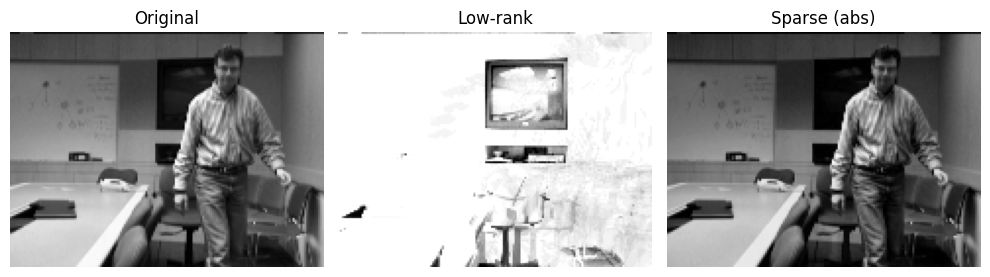

未开启自动下载，使用本地数据目录： ./MovedObject
找到 1746 张图片，示例：['./MovedObject/b00000.bmp', './MovedObject/b00001.bmp', './MovedObject/b00002.bmp', './MovedObject/b00003.bmp', './MovedObject/b00004.bmp']
选中的帧索引与路径：
1744 ./MovedObject/b01744.bmp
1745 ./MovedObject/hand_segmented_00985.BMP
1499 ./MovedObject/b01499.bmp
1500 ./MovedObject/b01500.bmp
1498 ./MovedObject/b01498.bmp
1496 ./MovedObject/b01496.bmp
1497 ./MovedObject/b01497.bmp
1394 ./MovedObject/b01394.bmp
1495 ./MovedObject/b01495.bmp
1393 ./MovedObject/b01393.bmp
1392 ./MovedObject/b01392.bmp
1395 ./MovedObject/b01395.bmp
887 ./MovedObject/b00887.bmp
643 ./MovedObject/b00643.bmp
642 ./MovedObject/b00642.bmp
1494 ./MovedObject/b01494.bmp
641 ./MovedObject/b00641.bmp
884 ./MovedObject/b00884.bmp
886 ./MovedObject/b00886.bmp
649 ./MovedObject/b00649.bmp
888 ./MovedObject/b00888.bmp
640 ./MovedObject/b00640.bmp
1391 ./MovedObject/b01391.bmp
883 ./MovedObject/b00883.bmp
885 ./MovedObject/b00885.bmp
1493 ./MovedObject/b01493.bmp
650 ./MovedObject/

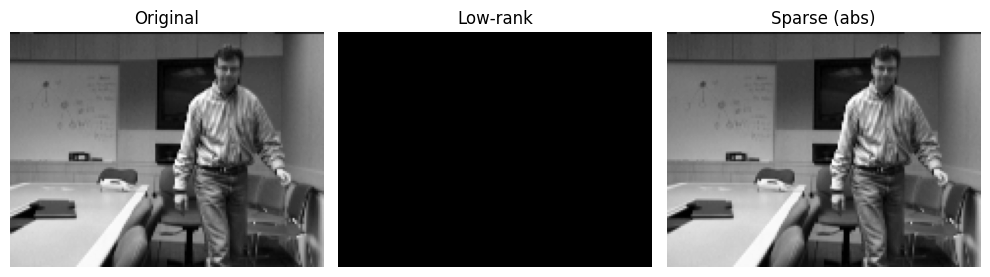

In [6]:
# 尝试不同参数组合 （不同lambda）
START_FRAME = 638  # 从数据集中第几帧开始取
NUM_FRAMES = 50
LAMBDA = None  # 若 None 则自动设置为 1/sqrt(max(m,n))
MU = 1e-3
MAX_ITER = 500
TOL = 1e-7
VERBOSE = True

for LAMBDA in [1e-2, 1e-3, 1e-4]:
    main()

In [1]:
"""

功能：
1) 尝试从微软下载 Wallflower MovedObject 数据集（若不可达，请手动下载并放到 local_data_dir）
2) 从数据集中读取所有图像，按帧间运动能量自动挑选 20 帧（可修改为手动选择）
3) 构建 observation matrix Y (19200 x 20)，运行 Robust PCA via ADMM 分解 Y = L + S
4) 保存每帧的原图 / 低秩背景 L / 稀疏前景 S 到 output 文件夹，并保存 numpy 文件

"""

import os
import sys
import numpy as np
import cv2
import zipfile
import requests
from io import BytesIO
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------ 用户可修改参数 ------------------
DOWNLOAD = False
DOWNLOAD_URL = "https://download.microsoft.com/download/MovedObject.zip" 
local_data_dir = "./MovedObject"   # 若下载失败，请把数据手动放这里（或改为你本地路径）
work_dir = "./rpca_output"
IMG_SIZE = (120, 160)  # height, width
START_FRAME = 638  # 从数据集中第几帧开始取
NUM_FRAMES = 20
LAMBDA = None  # 若 None 则自动设置为 1/sqrt(max(m,n))
MU = 1e-3
MAX_ITER = 500
TOL = 1e-7
VERBOSE = True
# ---------------------------------------------------

os.makedirs(local_data_dir, exist_ok=True)
os.makedirs(work_dir, exist_ok=True)

def try_download_and_extract(url, dest_folder):
    """
    尝试下载 zip 并解压到 dest_folder。
    如果下载失败或 URL 不可达，将返回 False。
    """
    try:
        print("尝试下载数据集...")
        # 逐块下载以显示进度
        resp = requests.get(url, stream=True, timeout=30)
        if resp.status_code != 200:
            print(f"下载失败: HTTP {resp.status_code}")
            return False
        total = int(resp.headers.get('content-length', 0))
        chunk_size = 1024*64
        bio = BytesIO()
        with tqdm(total=total, unit='B', unit_scale=True, desc='Downloading') as pbar:
            for chunk in resp.iter_content(chunk_size=chunk_size):
                if chunk:
                    bio.write(chunk)
                    pbar.update(len(chunk))
        bio.seek(0)
        print("解压缩...")
        with zipfile.ZipFile(bio) as z:
            z.extractall(dest_folder)
        print("下载并解压完成，文件位于：", dest_folder)
        return True
    except Exception as e:
        print("自动下载/解压失败：", e)
        return False

def gather_image_paths(root_dir):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    paths = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(exts):
                paths.append(os.path.join(root, f))
    paths = sorted(paths)
    return paths

def read_and_preprocess(path, size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise RuntimeError(f"Failed to read image {path}")
    img = cv2.resize(img, (size[1], size[0]))  # cv2 resize uses (w,h)
    return img

def select_frames_by_motion(img_paths, size, num_select):
    """
    自动选择具有较多运动的帧：
    - 先读取并缩放所有帧为 size
    - 计算相邻帧 abs diff 的 sum（motion energy）
    - 选取得分最高的 num_select 帧
    """
    imgs = []
    for p in img_paths:
        try:
            imgs.append(read_and_preprocess(p, size))
        except:
            imgs.append(None)
    # 计算帧间差（对缺失的跳过）
    energies = []
    for i in range(len(imgs)):
        if imgs[i] is None:
            energies.append(0)
            continue
        # use diff to median of neighbors (previous and next if exist)
        neighbors = []
        if i-1 >= 0 and imgs[i-1] is not None:
            neighbors.append(imgs[i-1])
        if i+1 < len(imgs) and imgs[i+1] is not None:
            neighbors.append(imgs[i+1])
        if len(neighbors) == 0:
            energies.append(0)
            continue
        # compute average absolute difference to neighbors
        diffs = [np.abs(imgs[i].astype(np.float32) - n.astype(np.float32)) for n in neighbors]
        energy = np.sum(np.stack(diffs), axis=(1,2)).sum() if len(diffs)>1 else diffs[0].sum()
        energies.append(energy)
    indices = np.argsort(energies)[::-1]  # desc
    selected = []
    for idx in indices:
        if imgs[idx] is not None:
            selected.append((idx, img_paths[idx]))
        if len(selected) >= num_select:
            break
    return selected

# ------------------ Robust PCA (ADMM) 工具 ------------------
def svt(X, tau):
    # X: (m, n)
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    s_thresh = np.maximum(s - tau, 0)
    return (U * s_thresh) @ Vt  # broadcasting U * s -> U @ diag(s)

def shrink(X, tau):
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0.0)

def robust_pca_admm(Y, lam=None, mu=1e-3, max_iter=500, tol=1e-7, verbose=True):
    m, n = Y.shape
    if lam is None:
        lam = 1.0 / np.sqrt(max(m, n))
    L = np.zeros_like(Y)
    S = np.zeros_like(Y)
    Z = np.zeros_like(Y)
    normY = np.linalg.norm(Y, 'fro')
    for k in range(max_iter):
        # update L via SVT
        L = svt(Y - S + Z/mu, 1.0/mu)
        # update S via shrinkage
        S = shrink(Y - L + Z/mu, lam/mu)
        # dual update
        residual = Y - L - S
        Z = Z + mu * residual
        err = np.linalg.norm(residual, 'fro') / (normY + 1e-12)
        if verbose and (k % 50 == 0 or err < tol):
            print(f"iter {k:4d}, rel_err={err:.3e}")
        if err < tol:
            break
    return L, S

# ------------------ 主流程 ------------------
def main():
    # 1) 尝试自动下载 (如果 DOWNLOAD==True)
    if DOWNLOAD:
        ok = try_download_and_extract(DOWNLOAD_URL, local_data_dir)
        if not ok:
            print("自动下载未成功，请将数据集手动放到", local_data_dir)
    else:
        print("未开启自动下载，使用本地数据目录：", local_data_dir)

    # 2) 收集图片列表
    img_paths = gather_image_paths(local_data_dir)
    if len(img_paths) == 0:
        print("未在数据目录找到图片。请确认数据已解压或将图片放到：", local_data_dir)
        sys.exit(1)
    print(f"找到 {len(img_paths)} 张图片，示例：{img_paths[:5]}")

    # 3) 自动选帧或截取前 N 帧
    selected = select_frames_by_motion(img_paths, IMG_SIZE, NUM_FRAMES)
    if len(selected) < NUM_FRAMES:
        print("自动选帧不足，改为直接取前 N 张")
        selected = [(i, p) for i, p in enumerate(img_paths[START_FRAME:START_FRAME+NUM_FRAMES])]
    print("选中的帧索引与路径：")
    for idx, p in selected:
        print(idx, p)

    # 4) 构建 Y 矩阵
    images_vecs = []
    chosen_paths = []
    for idx, p in selected:
        img = read_and_preprocess(p, IMG_SIZE)
        images_vecs.append(img.flatten().astype(np.float32))
        chosen_paths.append(p)
    Y = np.column_stack(images_vecs)  # shape (m, n)
    m, n = Y.shape
    print("构建 observation matrix Y, shape=", Y.shape)

    # 5) 运行 Robust PCA (ADMM)
    lam = LAMBDA if LAMBDA is not None else 1.0 / np.sqrt(max(m, n))
    print(f"Running Robust PCA with lambda={lam:.4e}, mu={MU}, max_iter={MAX_ITER}, num_frames={NUM_FRAMES}")
    L, S = robust_pca_admm(Y, lam=lam, mu=MU, max_iter=MAX_ITER, tol=TOL, verbose=VERBOSE)

    # 6) 保存结果：每帧的原图 / L / S，和 .npy 文件
    np.save(os.path.join(work_dir, "Y.npy"), Y)
    np.save(os.path.join(work_dir, "L.npy"), L)
    np.save(os.path.join(work_dir, "S.npy"), S)
    print("保存矩阵 Y, L, S 到", work_dir)

    # 保存每帧图片
    for i in range(n):
        orig = Y[:, i].reshape(IMG_SIZE)
        low = L[:, i].reshape(IMG_SIZE)
        sprs = S[:, i].reshape(IMG_SIZE)
        # 为了可视化，将 low 和 sparse 做归一化显示
        low_disp = np.clip(low, 0, 255)
        # sparse 可能有正负，用绝对值并适当放大以便查看
        sprs_disp = np.clip(np.abs(sprs), 0, np.percentile(np.abs(sprs), 99))
        # normalize to 0-255
        low_disp = ((low_disp - low_disp.min()) / (np.ptp(low_disp) + 1e-12) * 255).astype(np.uint8)
        sprs_disp = ((sprs_disp - sprs_disp.min()) / (np.ptp(sprs_disp) + 1e-12) * 255).astype(np.uint8)
        orig_u = np.clip(orig, 0, 255).astype(np.uint8)

        out_orig = os.path.join(work_dir, f"frame_{i:03d}_orig.png")
        out_low  = os.path.join(work_dir, f"frame_{i:03d}_low.png")
        out_sprs = os.path.join(work_dir, f"frame_{i:03d}_sparse.png")
        cv2.imwrite(out_orig, orig_u)
        cv2.imwrite(out_low, low_disp)
        cv2.imwrite(out_sprs, sprs_disp)

        # 组合图
        combo = np.hstack([orig_u, low_disp, sprs_disp])
        cv2.imwrite(os.path.join(work_dir, f"frame_{i:03d}_combo.png"), combo)

    print("已保存每帧的结果图：", work_dir)

    # 7) 显示一个示例：第 n//2 帧
    idx_show = n // 2
    orig = Y[:, idx_show].reshape(IMG_SIZE)
    low = L[:, idx_show].reshape(IMG_SIZE)
    sprs = S[:, idx_show].reshape(IMG_SIZE)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.title("Original"); plt.imshow(orig, cmap='gray'); plt.axis('off')
    plt.subplot(1,3,2); plt.title("Low-rank"); plt.imshow(low, cmap='gray'); plt.axis('off')
    plt.subplot(1,3,3); plt.title("Sparse (abs)"); plt.imshow(np.abs(sprs), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()

# if __name__ == "__main__":
#     main()

未开启自动下载，使用本地数据目录： ./MovedObject
找到 1746 张图片，示例：['./MovedObject/b00000.bmp', './MovedObject/b00001.bmp', './MovedObject/b00002.bmp', './MovedObject/b00003.bmp', './MovedObject/b00004.bmp']
选中的帧索引与路径：
1744 ./MovedObject/b01744.bmp
1745 ./MovedObject/hand_segmented_00985.BMP
1499 ./MovedObject/b01499.bmp
1500 ./MovedObject/b01500.bmp
1498 ./MovedObject/b01498.bmp
1496 ./MovedObject/b01496.bmp
1497 ./MovedObject/b01497.bmp
1394 ./MovedObject/b01394.bmp
1495 ./MovedObject/b01495.bmp
1393 ./MovedObject/b01393.bmp
1392 ./MovedObject/b01392.bmp
1395 ./MovedObject/b01395.bmp
887 ./MovedObject/b00887.bmp
643 ./MovedObject/b00643.bmp
642 ./MovedObject/b00642.bmp
1494 ./MovedObject/b01494.bmp
641 ./MovedObject/b00641.bmp
884 ./MovedObject/b00884.bmp
886 ./MovedObject/b00886.bmp
649 ./MovedObject/b00649.bmp
888 ./MovedObject/b00888.bmp
640 ./MovedObject/b00640.bmp
1391 ./MovedObject/b01391.bmp
883 ./MovedObject/b00883.bmp
885 ./MovedObject/b00885.bmp
1493 ./MovedObject/b01493.bmp
650 ./MovedObject/

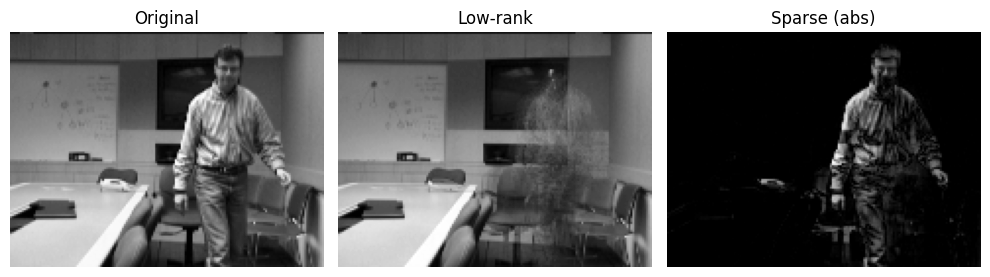

未开启自动下载，使用本地数据目录： ./MovedObject
找到 1746 张图片，示例：['./MovedObject/b00000.bmp', './MovedObject/b00001.bmp', './MovedObject/b00002.bmp', './MovedObject/b00003.bmp', './MovedObject/b00004.bmp']
选中的帧索引与路径：
1744 ./MovedObject/b01744.bmp
1745 ./MovedObject/hand_segmented_00985.BMP
1499 ./MovedObject/b01499.bmp
1500 ./MovedObject/b01500.bmp
1498 ./MovedObject/b01498.bmp
1496 ./MovedObject/b01496.bmp
1497 ./MovedObject/b01497.bmp
1394 ./MovedObject/b01394.bmp
1495 ./MovedObject/b01495.bmp
1393 ./MovedObject/b01393.bmp
1392 ./MovedObject/b01392.bmp
1395 ./MovedObject/b01395.bmp
887 ./MovedObject/b00887.bmp
643 ./MovedObject/b00643.bmp
642 ./MovedObject/b00642.bmp
1494 ./MovedObject/b01494.bmp
641 ./MovedObject/b00641.bmp
884 ./MovedObject/b00884.bmp
886 ./MovedObject/b00886.bmp
649 ./MovedObject/b00649.bmp
888 ./MovedObject/b00888.bmp
640 ./MovedObject/b00640.bmp
1391 ./MovedObject/b01391.bmp
883 ./MovedObject/b00883.bmp
885 ./MovedObject/b00885.bmp
1493 ./MovedObject/b01493.bmp
650 ./MovedObject/

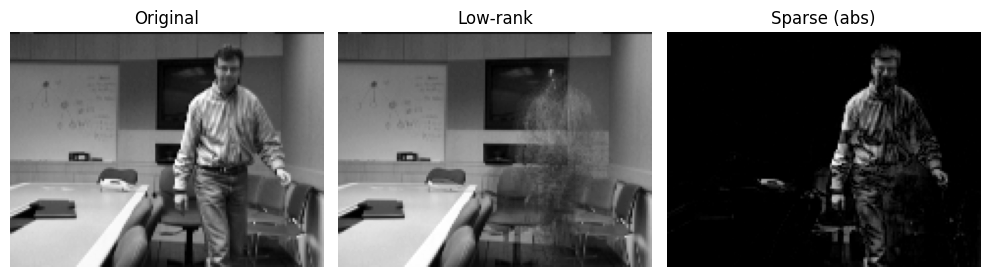

未开启自动下载，使用本地数据目录： ./MovedObject
找到 1746 张图片，示例：['./MovedObject/b00000.bmp', './MovedObject/b00001.bmp', './MovedObject/b00002.bmp', './MovedObject/b00003.bmp', './MovedObject/b00004.bmp']
选中的帧索引与路径：
1744 ./MovedObject/b01744.bmp
1745 ./MovedObject/hand_segmented_00985.BMP
1499 ./MovedObject/b01499.bmp
1500 ./MovedObject/b01500.bmp
1498 ./MovedObject/b01498.bmp
1496 ./MovedObject/b01496.bmp
1497 ./MovedObject/b01497.bmp
1394 ./MovedObject/b01394.bmp
1495 ./MovedObject/b01495.bmp
1393 ./MovedObject/b01393.bmp
1392 ./MovedObject/b01392.bmp
1395 ./MovedObject/b01395.bmp
887 ./MovedObject/b00887.bmp
643 ./MovedObject/b00643.bmp
642 ./MovedObject/b00642.bmp
1494 ./MovedObject/b01494.bmp
641 ./MovedObject/b00641.bmp
884 ./MovedObject/b00884.bmp
886 ./MovedObject/b00886.bmp
649 ./MovedObject/b00649.bmp
888 ./MovedObject/b00888.bmp
640 ./MovedObject/b00640.bmp
1391 ./MovedObject/b01391.bmp
883 ./MovedObject/b00883.bmp
885 ./MovedObject/b00885.bmp
1493 ./MovedObject/b01493.bmp
650 ./MovedObject/

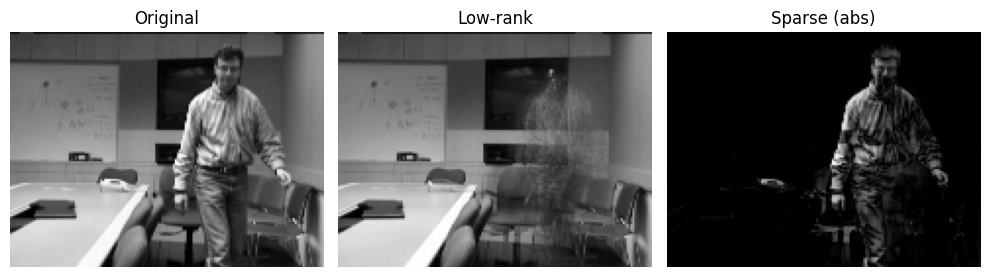

In [2]:
# 尝试不同参数组合 （不同mu）
START_FRAME = 638  # 从数据集中第几帧开始取
NUM_FRAMES = 50
LAMBDA = 1e-2  # 若 None 则自动设置为 1/sqrt(max(m,n))
MU = 1e-3
MAX_ITER = 500
TOL = 1e-7
VERBOSE = True

for MU in [1e-3, 1e-4, 1e-5]:
    main()